In [1]:
!pip install torch torchvision matplotlib scikit-learn pillow

In [2]:
# Dataset paths (based on your folder structure)
BASE_DIR = "data/Chest-X-Ray/Chest-X-Ray"
IMG_DIR = BASE_DIR + "/image"
MASK_DIR = BASE_DIR + "/mask"

import os
print("Number of images:", len(os.listdir(IMG_DIR)))
print("Number of masks:", len(os.listdir(MASK_DIR)))


Number of images: 704
Number of masks: 704


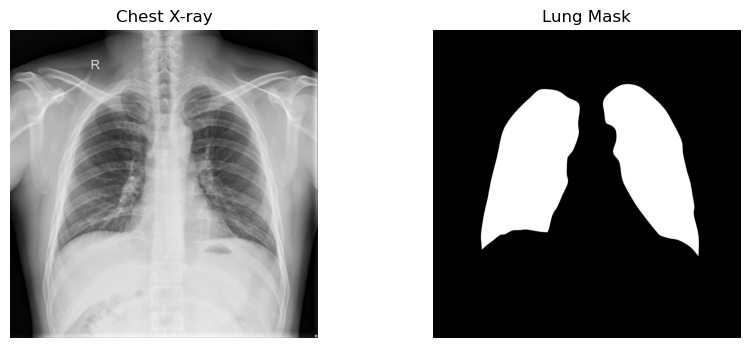

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

img_name = sorted(os.listdir(IMG_DIR))[0]

img = Image.open(os.path.join(IMG_DIR, img_name)).convert("L")
mask = Image.open(os.path.join(MASK_DIR, img_name)).convert("L")

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Chest X-ray")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Lung Mask")
plt.axis("off")

plt.show()


In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class LungDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        def is_image_file(name):
            name = name.lower()
            return name.endswith((".png", ".jpg", ".jpeg", ".bmp"))

        self.img_files = sorted([f for f in os.listdir(img_dir) if is_image_file(f)])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if is_image_file(f)])

        # safety check
        assert len(self.img_files) == len(self.mask_files), "Images and masks count mismatch!"

        self.size = size

        self.img_tf = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),  # -> [0,1]
        ])

        self.mask_tf = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),  # -> [0,1]
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        fname = self.img_files[idx]

        img_path = os.path.join(self.img_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        img = self.img_tf(img)     # shape: [1, H, W]
        mask = self.mask_tf(mask)  # shape: [1, H, W]

        # Make mask strictly 0/1 (binary)
        mask = (mask > 0.5).float()

        return img, mask


In [5]:
dataset = LungDataset(IMG_DIR, MASK_DIR, size=128)

print("Dataset size:", len(dataset))

x, y = dataset[0]
print("Image shape:", x.shape, "min/max:", float(x.min()), float(x.max()))
print("Mask shape:", y.shape, "unique values:", torch.unique(y))


Dataset size: 704
Image shape: torch.Size([1, 128, 128]) min/max: 0.0 0.9411764740943909
Mask shape: torch.Size([1, 128, 128]) unique values: tensor([0., 1.])


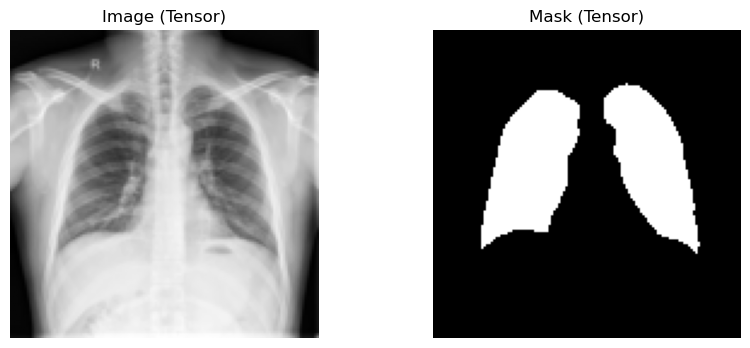

In [6]:
import matplotlib.pyplot as plt

x, y = dataset[0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(x.squeeze().numpy(), cmap="gray")
plt.title("Image (Tensor)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(y.squeeze().numpy(), cmap="gray")
plt.title("Mask (Tensor)")
plt.axis("off")

plt.show()


In [7]:
from torch.utils.data import random_split
import torch

# reproducibility
seed = 42
torch.manual_seed(seed)

n = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))


Train: 563
Val: 70
Test: 71


In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2
NUM_WORKERS = 0  # keep 0 on Windows to avoid worker issues

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

x_batch, y_batch = next(iter(train_loader))
print("Batch image:", x_batch.shape)
print("Batch mask:", y_batch.shape)
print("Mask unique values in batch:", torch.unique(y_batch))


Batch image: torch.Size([2, 1, 128, 128])
Batch mask: torch.Size([2, 1, 128, 128])
Mask unique values in batch: tensor([0., 1.])


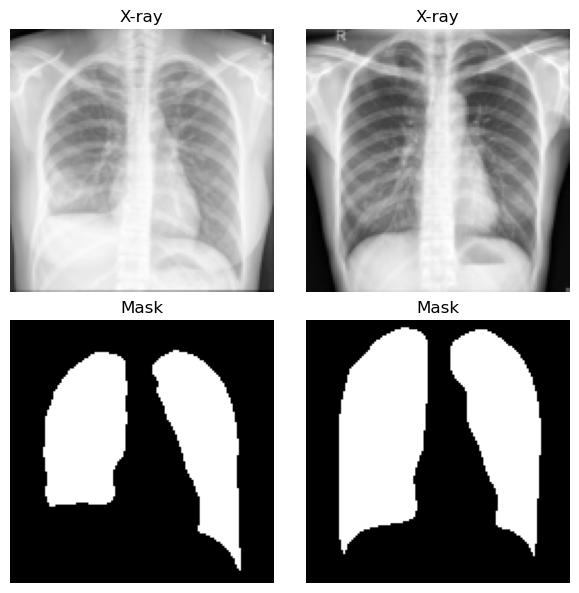

In [9]:
# import matplotlib.pyplot as plt

# x_batch, y_batch = next(iter(train_loader))

# plt.figure(figsize=(12,6))
# for i in range(4):
#     plt.subplot(2,4,i+1)
#     plt.imshow(x_batch[i].squeeze().numpy(), cmap="gray")
#     plt.axis("off")
#     plt.title("X-ray")

#     plt.subplot(2,4,i+5)
#     plt.imshow(y_batch[i].squeeze().numpy(), cmap="gray")
#     plt.axis("off")
#     plt.title("Mask")

# plt.tight_layout()
# plt.show()
import matplotlib.pyplot as plt

x_batch, y_batch = next(iter(train_loader))

plt.figure(figsize=(12,6))

n = min(4, x_batch.shape[0])  # batch size might be 2

for i in range(n):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i].squeeze().numpy(), cmap="gray")
    plt.axis("off")
    plt.title("X-ray")

    plt.subplot(2,4,i+5)
    plt.imshow(y_batch[i].squeeze().numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Mask")

plt.tight_layout()
plt.show()


In [10]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        ch = in_channels
        for f in features:
            self.downs.append(DoubleConv(ch, f))
            ch = f

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder
        for f in reversed(features):
            self.ups.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(f*2, f))

        # Output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # upsample
            skip = skip_connections[idx//2]

            # handle odd sizes (safety)
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)  # logits


In [11]:
def dice_coeff(pred, target, eps=1e-6):
    # pred/target: (B,1,H,W) in {0,1}
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean()

def iou_coeff(pred, target, eps=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    total = (pred + target).sum(dim=(2,3))
    union = total - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean()

bce_loss = nn.BCEWithLogitsLoss()

def loss_fn(logits, target):
    # logits -> prob -> bin
    prob = torch.sigmoid(logits)
    dice = 1 - dice_coeff((prob > 0.5).float(), target)
    bce = bce_loss(logits, target)
    return 0.5*bce + 0.5*dice


In [12]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
# model = UNet(in_channels=1, out_channels=1).to(device)

# x_batch, y_batch = next(iter(train_loader))
# x_batch = x_batch.to(device)

# with torch.no_grad():
#     logits = model(x_batch)

# print("Input:", x_batch.shape)
# print("Output logits:", logits.shape)
import torch, gc

# clean up before using GPU
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(
    in_channels=1,
    out_channels=1,
    features=[32, 64, 128, 256]
).to(device)

print("Using device:", device)

x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(device)

with torch.no_grad():
    out = model(x_batch)

print("Input:", x_batch.shape)
print("Output:", out.shape)



Using device: cpu
Input: torch.Size([2, 1, 128, 128])
Output: torch.Size([2, 1, 128, 128])


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("one GPU step start")
model.train()

x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

optimizer.zero_grad()
logits = model(x)
loss = loss_fn(logits, y)
loss.backward()
optimizer.step()

print("✅ one GPU step done | loss =", float(loss.item()))


one GPU step start
✅ one GPU step done | loss = 0.692790687084198


In [14]:
import torch
import numpy as np

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            prob = torch.sigmoid(logits)
            pred = (prob > 0.5).float()
            d = dice_coeff(pred, y).item()
            j = iou_coeff(pred, y).item()

        total_loss += loss.item()
        total_dice += d
        total_iou += j
        n_batches += 1

    return total_loss/n_batches, total_dice/n_batches, total_iou/n_batches


@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        prob = torch.sigmoid(logits)
        pred = (prob > 0.5).float()

        d = dice_coeff(pred, y).item()
        j = iou_coeff(pred, y).item()

        total_loss += loss.item()
        total_dice += d
        total_iou += j
        n_batches += 1

    return total_loss/n_batches, total_dice/n_batches, total_iou/n_batches


In [15]:
import os, torch, gc
os.makedirs("results", exist_ok=True)

EPOCHS = 3          # start small
best_val_dice = -1.0

history = {"train_loss":[], "val_loss":[], "train_dice":[], "val_dice":[]}

print("training started")

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_dice, tr_iou = train_one_epoch(model, train_loader, optimizer, device)
    va_loss, va_dice, va_iou = validate(model, val_loader, device)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_dice"].append(tr_dice)
    history["val_dice"].append(va_dice)

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} dice {tr_dice:.4f} || "
          f"val loss {va_loss:.4f} dice {va_dice:.4f}")

    if va_dice > best_val_dice:
        best_val_dice = va_dice
        torch.save(model.state_dict(), "results/best_unet.pth")
        print("✅ saved results/best_unet.pth")

    # optional: keep GPU memory chill between epochs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("✅ done | best_val_dice =", best_val_dice)
print("results folder:", os.listdir("results"))


training started
Epoch 1/3 | train loss 0.1148 dice 0.9227 || val loss 0.0628 dice 0.9535
✅ saved results/best_unet.pth
Epoch 2/3 | train loss 0.0644 dice 0.9476 || val loss 0.0526 dice 0.9562
✅ saved results/best_unet.pth
Epoch 3/3 | train loss 0.0519 dice 0.9569 || val loss 0.0499 dice 0.9577
✅ saved results/best_unet.pth
✅ done | best_val_dice = 0.9576687591416495
results folder: ['best_unet.pth', 'hello.txt']


In [16]:
import torch

# load best model
model.load_state_dict(torch.load("results/best_unet.pth", map_location=device))

test_loss, test_dice, test_iou = validate(model, test_loader, device)

print("📌 TEST RESULTS")
print("loss:", round(test_loss, 4))
print("dice:", round(test_dice, 4))
print("iou:", round(test_iou, 4))


📌 TEST RESULTS
loss: 0.054
dice: 0.9529
iou: 0.9136


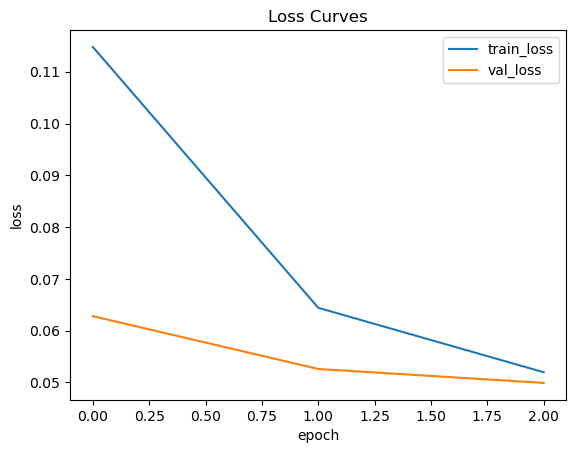

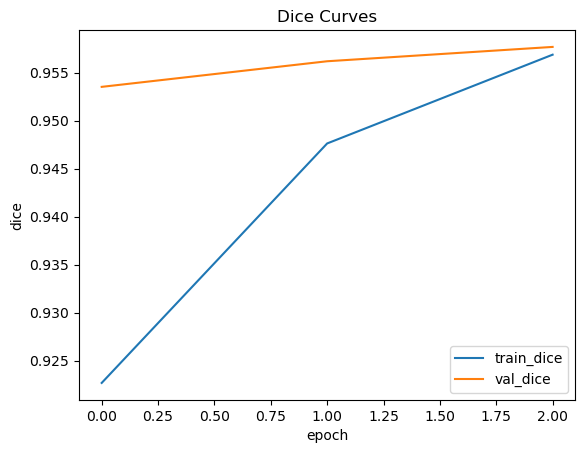

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss Curves")
plt.savefig("results/loss_curves.png", bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(history["train_dice"], label="train_dice")
plt.plot(history["val_dice"], label="val_dice")
plt.xlabel("epoch")
plt.ylabel("dice")
plt.legend()
plt.title("Dice Curves")
plt.savefig("results/dice_curves.png", bbox_inches="tight")
plt.show()


In [21]:
import os
import torch
import numpy as np
from PIL import Image

@torch.no_grad()
def save_predictions(model, loader, device, out_dir="results/preds", n=8):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()

    saved = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        prob = torch.sigmoid(logits)
        pred = (prob > 0.5).float()

        x_np = x.cpu().numpy()
        y_np = y.cpu().numpy()
        p_np = pred.cpu().numpy()

        for i in range(x_np.shape[0]):
            if saved >= n:
                print(f"✅ Saved {saved} prediction samples to {out_dir}")
                return

            # Convert to uint8 images
            img = (x_np[i, 0] * 255).astype(np.uint8)
            gt  = (y_np[i, 0] * 255).astype(np.uint8)
            pr  = (p_np[i, 0] * 255).astype(np.uint8)

            # ---------- RED OVERLAY (CLEAN + SAFE) ----------
            rgb = np.stack([img, img, img], axis=-1).astype(np.float32)

            alpha = 0.4  # transparency strength
            mask = (pr > 127).astype(np.float32)

            red_layer = rgb.copy()
            red_layer[..., 0] = 255  # pure red

            overlay = rgb * (1 - alpha * mask[..., None]) + red_layer * (alpha * mask[..., None])
            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            # ------------------------------------------------

            # Save outputs
            Image.fromarray(img).save(os.path.join(out_dir, f"{saved}_img.png"))
            Image.fromarray(gt).save(os.path.join(out_dir, f"{saved}_gt.png"))
            Image.fromarray(pr).save(os.path.join(out_dir, f"{saved}_pred.png"))
            Image.fromarray(overlay).save(os.path.join(out_dir, f"{saved}_overlay.png"))

            saved += 1

    print(f"✅ Saved {saved} prediction samples to {out_dir}")


In [22]:
# make sure best model is loaded first
model.load_state_dict(torch.load("results/best_unet.pth", map_location=device))

# save prediction examples from the TEST set
save_predictions(model, test_loader, device, out_dir="results/preds", n=8)

print("✅ saved prediction images to results/preds")
print(os.listdir("results/preds")[:10])


✅ Saved 8 prediction samples to results/preds
✅ saved prediction images to results/preds
['0_gt.png', '0_img.png', '0_overlay.png', '0_pred.png', '1_gt.png', '1_img.png', '1_overlay.png', '1_pred.png', '2_gt.png', '2_img.png']


In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt

os.makedirs("results/montage", exist_ok=True)

def make_montage(i, preds_dir="results/preds", out_dir="results/montage"):
    img = Image.open(f"{preds_dir}/{i}_img.png")
    gt  = Image.open(f"{preds_dir}/{i}_gt.png")
    pr  = Image.open(f"{preds_dir}/{i}_pred.png")
    ov  = Image.open(f"{preds_dir}/{i}_overlay.png")

    plt.figure(figsize=(12,3))
    for k, (im, title) in enumerate([(img,"X-ray"), (gt,"Ground Truth"), (pr,"Prediction"), (ov,"Overlay")]):
        plt.subplot(1,4,k+1)
        plt.imshow(im)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"{out_dir}/sample_{i}.png", dpi=160, bbox_inches="tight")
    plt.close()

# change 8 if you saved more/less
N = 8
for i in range(N):
    make_montage(i)

print("✅ montages saved in results/montage/")
print(os.listdir("results/montage")[:10])


✅ montages saved in results/montage/
['sample_0.png', 'sample_1.png', 'sample_2.png', 'sample_3.png', 'sample_4.png', 'sample_5.png', 'sample_6.png', 'sample_7.png']


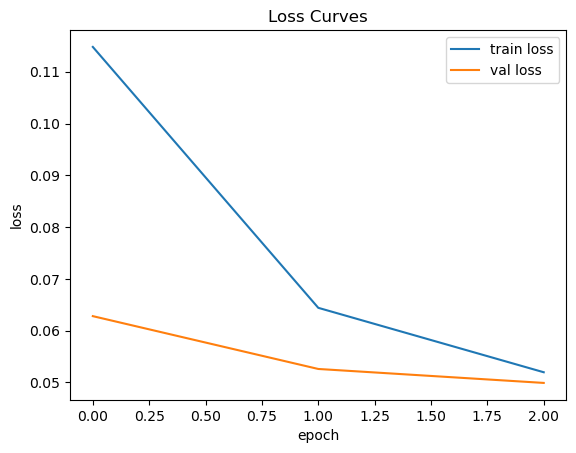

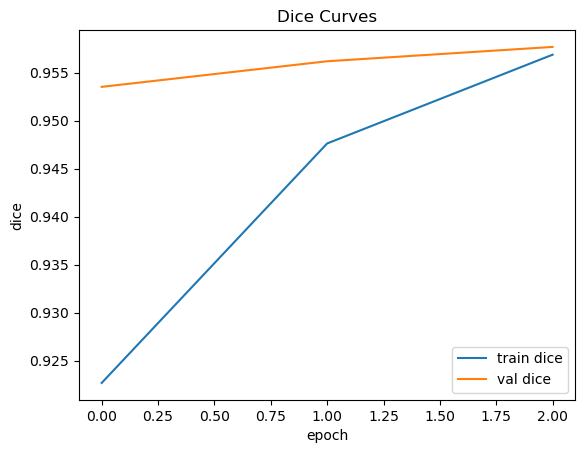

✅ saved results/loss_curves.png and results/dice_curves.png


In [24]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss Curves")
plt.legend()
plt.savefig("results/loss_curves.png", dpi=160, bbox_inches="tight")
plt.show()

# Dice curve
plt.figure()
plt.plot(history["train_dice"], label="train dice")
plt.plot(history["val_dice"], label="val dice")
plt.xlabel("epoch")
plt.ylabel("dice")
plt.title("Dice Curves")
plt.legend()
plt.savefig("results/dice_curves.png", dpi=160, bbox_inches="tight")
plt.show()

print("✅ saved results/loss_curves.png and results/dice_curves.png")
